In [1]:
from sklearn.model_selection import train_test_split
import pymc3 as pm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
from sklearn.metrics import r2_score



In [2]:
import arviz as az

## Bayesian Linear Regression with PyMC3

In this task you are required to use PyMC3 to run a Bayesian Linear regression on the California housing dataset which is easily available via the sklearn.datasets.fetch_california_housing function. The goal with this dataset is to predict the median house in a 'block' in California. A block is a small geographical area with a population of between 600 and 3000 people. Each datapoint in this dataset corresponds to a block. Consult the scikit-learn documentation for details of the predictor variables.

   As always with Bayseian analysis it is up to you to choose your prior distributions. Be sure to justify your choice of priors in your report. What do the results produced by PyMC3 tell you about what influences house value in California? Is it necessary and/or useful to transform the data in some way before running MCMC?

#### Solution Attempt:

The first task to understand with the dataset is how the data is stored. Once we understand the structure of the data then we can work towards incorporating it with the PyMC3 model. The first task therefore is to call the fetch_california_housing function and store it in a dataset. Note at this point we haven't looked at the documentation yet. Let's look at the documentation to ensure we're trying something sensible. 

sklearn.datasets.fetch_california_housing(*, data_home=None, download_if_missing=True, return_X_y=False, as_frame=False)

In [3]:
X,y=fetch_california_housing(return_X_y=True)

In [4]:
print(f"X.shape: {X.shape} , y.shape: { y.shape}")

X.shape: (20640, 8) , y.shape: (20640,)


In [5]:
print(X[0,:], y[0])

[   8.3252       41.            6.98412698    1.02380952  322.
    2.55555556   37.88       -122.23      ] 4.526


Essentially we now have a dataset X that has 20640 rows and 8 features with a corresponding target vector stored in y. Since, the feature types is not exactly clear, let's study the documentation a little further to understand the dataset.

We have the following information from the documentation confirming our initial hunch. The data indeed has 8 features and a target column vector.

- Samples total: 20640
- Dimensionality: 8
- Features: real
- Target: real 0.15 - 5.

##### Number of Attributes
8 numeric, predictive attributes and the target

##### Attribute Information
1. MedInc median income in block
2. HouseAge median house age in block
3. AveRooms average number of rooms
4. AveBedrms average number of bedrooms
5. Population block population
6. AveOccup average house occupancy
7. Latitude house block latitude
8. Longitude house block longitude

While we can assume the order the data is stored, we can perform another check to confirm that y is indeed the target by looking at the min and max.

In [6]:
print(f"min y: {np.min(y)}, max y: {np.max(y)}")

min y: 0.14999, max y: 5.00001


This ties in with what was provided in the dataset information suggesting it's okay to assume we have the right target for regression. Another method is to import as pandas dataframe. Let's see if that yields any further information on the dataset.

In [7]:
df =fetch_california_housing(as_frame=True)

In [8]:
type(df)

sklearn.utils.Bunch

This isn't as straightforward. Here's the documentation:

    framepandas DataFrame
    Only present when as_frame=True. DataFrame with data and target.
Lets google this quickly..

Turns out the bunch object has a number of self attributes that store some information. As shown here:
http://www.clungu.com/scikit-learn/tutorial/Scikit-learn/

In [5]:
df.DESCR

'.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 20640\n\n    :Number of Attributes: 8 numeric, predictive attributes and the target\n\n    :Attribute Information:\n        - MedInc        median income in block\n        - HouseAge      median house age in block\n        - AveRooms      average number of rooms\n        - AveBedrms     average number of bedrooms\n        - Population    block population\n        - AveOccup      average house occupancy\n        - Latitude      house block latitude\n        - Longitude     house block longitude\n\n    :Missing Attribute Values: None\n\nThis dataset was obtained from the StatLib repository.\nhttp://lib.stat.cmu.edu/datasets/\n\nThe target variable is the median house value for California districts.\n\nThis dataset was derived from the 1990 U.S. census, using one row per census\nblock group. A block group is the smallest geographical unit

So the bunch object(which should be a dataframe object at least according to my limited understanding of the documentation, are df objects always bunches? lets not go there for now..) has the DESCR attribute, but the X with dataset is a ndarray and doesn't have that information.

In [9]:
df.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [10]:
df.target_names

['MedHouseVal']

From the website it's clear we can handle the imported data a bit better-  we can simply work with the Bunch object and access the data through it's attributes-.i.e.

    BunchVar.data or BunchVar.feature_names
    
We've now decided that we're fairly confident that we've got the right data and have a handy reference to make sure we're utilising it correctly. 

    The goal with this dataset is to predict the median house in a 'block' in California. A block is a small geographical area with a population of between 600 and 3000 people. Each datapoint in this dataset corresponds to a block. Consult the scikit-learn documentation for details of the predictor variables.

From this the task is clear, run a Bayesian linear regression after splitting into test and train datasets. Let's proceed to split the data into training(70 %), test and validation(15% each):


In [11]:
train_inputs, rest_inputs, train_labels, rest_labels = train_test_split(df.data, df.target, test_size = 0.30)
valid_inputs, test_inputs, valid_labels, test_labels = train_test_split(rest_inputs, rest_labels, test_size = 0.5)

In [12]:
print(train_inputs.shape, 'type: ', type(train_inputs), type(train_labels))

(14448, 8) type:  <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [13]:
train_inputs.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [14]:
train_inputs.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14065,1.9886,17.0,3.421927,1.051495,1251.0,2.078073,32.75,-117.12
14697,3.8333,36.0,5.644315,1.005831,861.0,2.510204,32.79,-117.09
2535,2.4917,43.0,6.700508,1.091371,512.0,2.598985,39.47,-122.10
3444,2.6429,33.0,4.494565,1.043478,981.0,5.331522,34.25,-118.41
17161,11.3176,28.0,8.082290,1.033989,1489.0,2.663685,37.38,-122.21


Now that we have the data split, lets return to the lab. We can follow the PyMC3 skeleton to define priors. Since there are 8 original features, let's begin there. <sub>(*Side note: As it turns out asFrame=True saves the df inside the bunch object, if it turns out to be a problem we could always turn it back to false later*)</sub> Before we can do that let's first normalize.

In [15]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [16]:

# Normalising the dataset
train_inputs=normalize(train_inputs)
test_inputs=normalize(test_inputs)
valid_inputs=normalize(valid_inputs)
train_inputs.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14065,0.102668,0.313725,0.018260,0.020079,0.043693,0.002762,0.021277,0.731906
14697,0.229886,0.686275,0.034014,0.018724,0.030039,0.003623,0.025532,0.734964
2535,0.137364,0.823529,0.041502,0.021263,0.017820,0.003800,0.736170,0.224261


In [17]:
# gives a snapshot of the data stats- useful to pick priors
train_inputs.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,0.232961,0.541201,0.032486,0.021423,0.049962,0.004575,0.328427,0.480910
std,0.130320,0.246609,0.018535,0.015205,0.039456,0.009349,0.226750,0.204149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.143465,0.333333,0.025409,0.018725,0.027588,0.003460,0.146809,0.253823
50%,0.209501,0.549020,0.031030,0.019981,0.040717,0.004236,0.181915,0.590214
75%,0.294651,0.705882,0.036944,0.021465,0.060472,0.005154,0.548936,0.640163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
summary= pd.DataFrame(train_inputs.describe())

In [19]:
summary

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,0.232961,0.541201,0.032486,0.021423,0.049962,0.004575,0.328427,0.480910
std,0.130320,0.246609,0.018535,0.015205,0.039456,0.009349,0.226750,0.204149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.143465,0.333333,0.025409,0.018725,0.027588,0.003460,0.146809,0.253823
50%,0.209501,0.549020,0.031030,0.019981,0.040717,0.004236,0.181915,0.590214
75%,0.294651,0.705882,0.036944,0.021465,0.060472,0.005154,0.548936,0.640163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
summary.T['std']

MedInc        0.130320
HouseAge      0.246609
AveRooms      0.018535
AveBedrms     0.015205
Population    0.039456
AveOccup      0.009349
Latitude      0.226750
Longitude     0.204149
Name: std, dtype: float64

In [21]:

means=np.array(summary.T['mean'])
stds=np.array(summary.T['std'])


Before we can define the priors, lets head over to the PyMC3 website and understand the pm.Normal function first.

In [22]:
train_data=pd.concat([train_labels, train_inputs], axis=1)
train_data.head(4)

,MedHouseVal,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14065,1.192,0.102668,0.313725,0.018260,0.020079,0.043693,0.002762,0.021277,0.731906
14697,1.700,0.229886,0.686275,0.034014,0.018724,0.030039,0.003623,0.025532,0.734964
2535,0.771,0.137364,0.823529,0.041502,0.021263,0.017820,0.003800,0.736170,0.224261
3444,1.431,0.147791,0.627451,0.025864,0.019841,0.034240,0.009246,0.180851,0.600408


In [23]:
# formula for Bayseian Linear Regression
formula= 'MedHouseVal ~ '+' + '.join(['%s' % variable for variable in train_inputs.columns[:]])
formula

'MedHouseVal ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude'

In [24]:


cali_model=pm.Model()

with cali_model:
    
    # Using normal priors for model parameters
    family=pm.glm.families.Normal()
    
    # Creating model
    pm.GLM.from_formula(formula, data = train_data , family = family)
    
    # MCMC
    trace = pm.sample(draws=10000, chains=2, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, Longitude, Latitude, AveOccup, Population, AveBedrms, AveRooms, HouseAge, MedInc, Intercept]
Sampling 2 chains, 0 divergences: 100%|███████████████████████████████████████| 21000/21000 [03:30<00:00, 99.75draws/s]
The acceptance probability does not match the target. It is 0.8955760264752767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858898494044934, but should be close to 0.8. Try to increase the number of tuning steps.


Adapted from https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e

In [25]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\b_pau\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplo

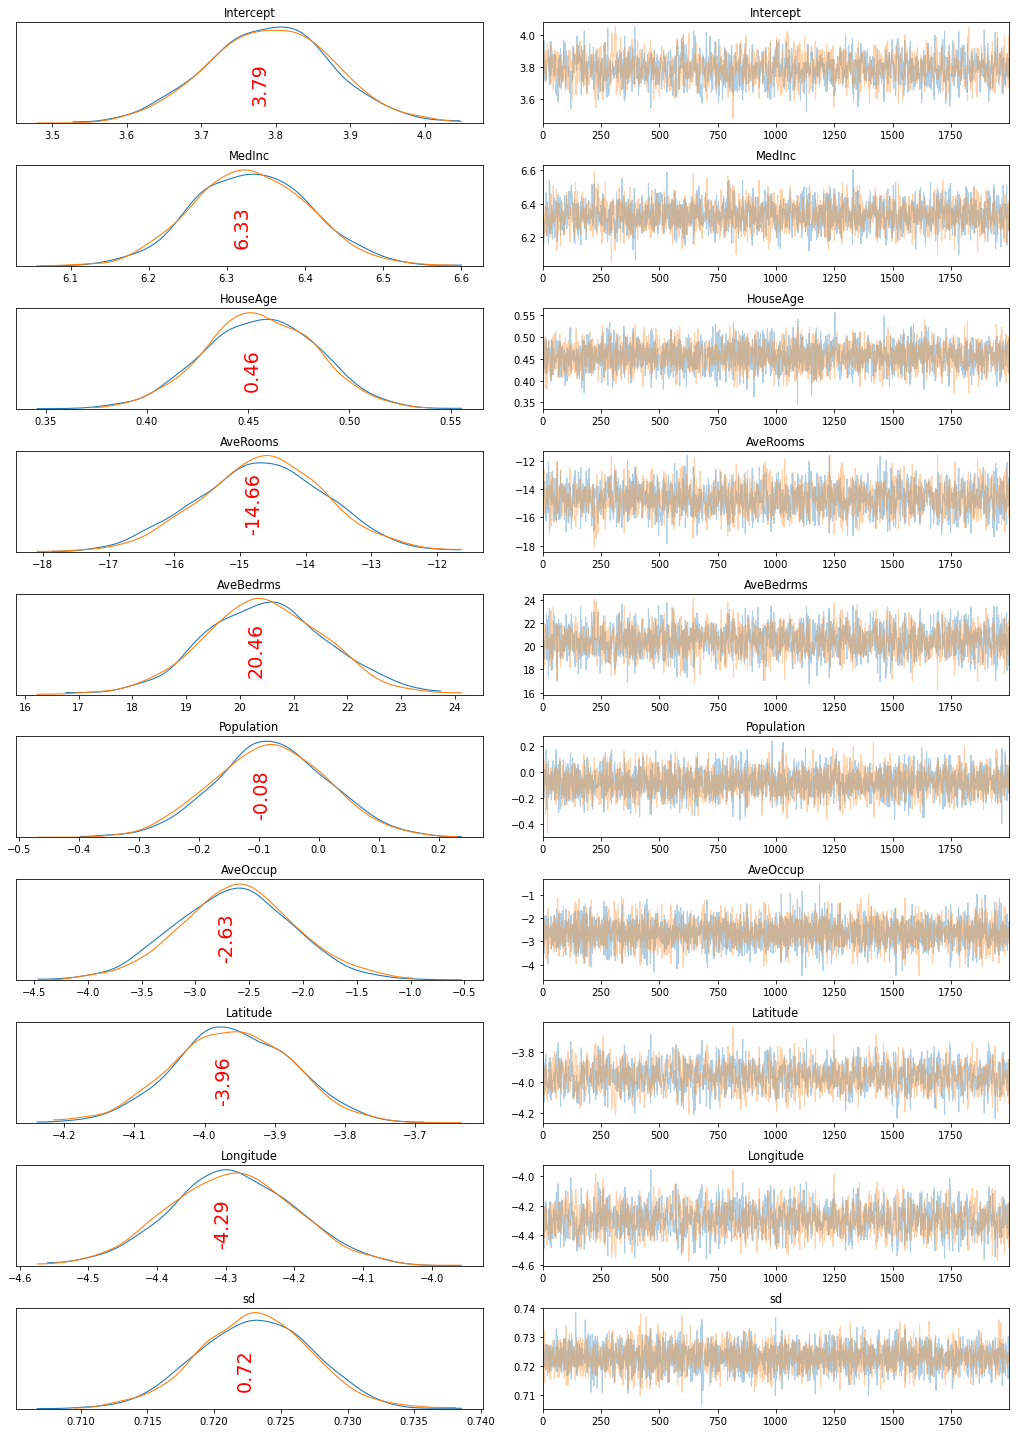

In [76]:
plot_trace(trace);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B01FEFB20>,
      dtype=object)

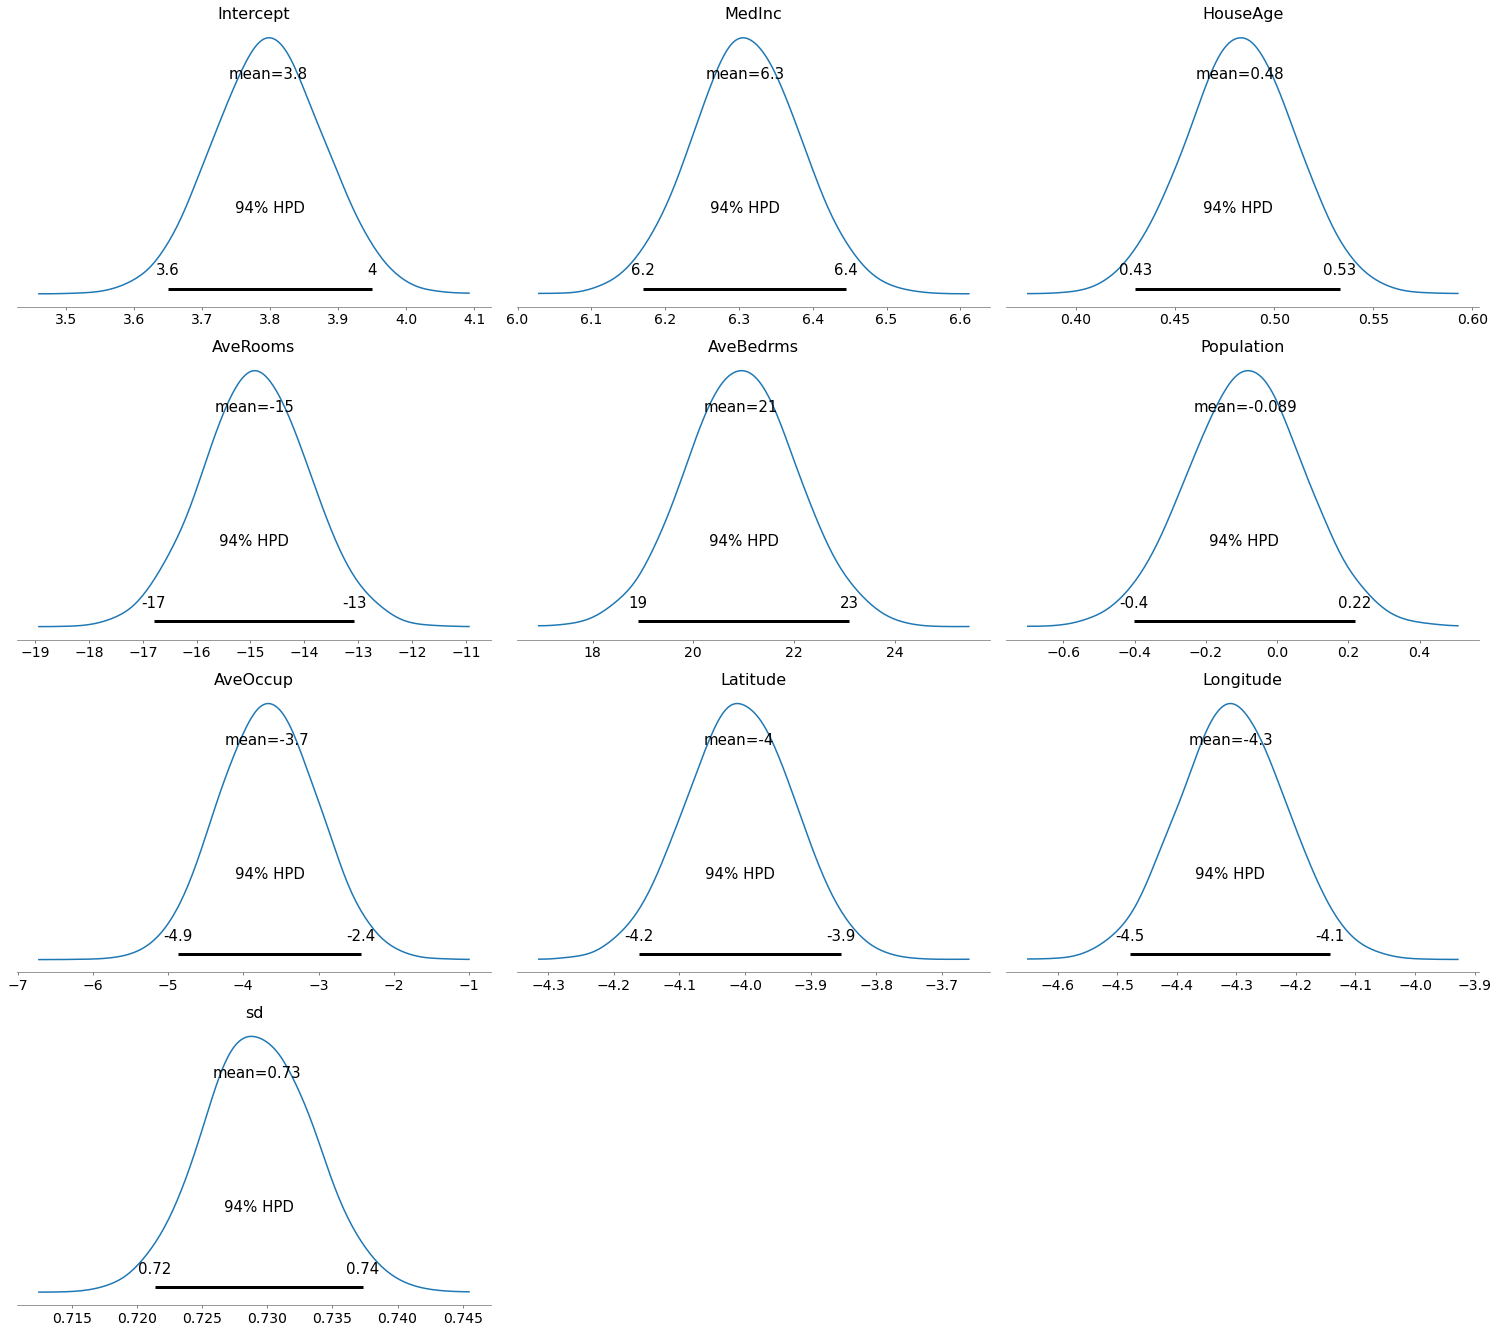

In [27]:
pm.plot_posterior(trace)

In [76]:
summary= pm.summary(trace)
print(summary)

type(summary)

              mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept    3.666  0.081   3.514    3.817      0.001    0.001    8260.0   
MedInc       6.386  0.073   6.250    6.526      0.001    0.001    8835.0   
HouseAge     0.506  0.027   0.454    0.557      0.000    0.000   14049.0   
AveRooms   -14.983  0.931 -16.672  -13.179      0.010    0.007    8808.0   
AveBedrms   21.369  1.095  19.382   23.509      0.011    0.008    9337.0   
Population   0.015  0.197  -0.357    0.387      0.001    0.001   18261.0   
AveOccup    -4.621  0.661  -5.869   -3.395      0.005    0.004   17312.0   
Latitude    -3.868  0.081  -4.022   -3.717      0.001    0.001    8831.0   
Longitude   -4.210  0.090  -4.383   -4.047      0.001    0.001    9107.0   
sd           0.724  0.004   0.716    0.732      0.000    0.000   19299.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
Intercept    8258.0    8259.0   10600.0    1.0  
MedInc       8830.0    8831.0   12376.0    1.0  
HouseAge    1385

pandas.core.frame.DataFrame

In [28]:
def evaluation(test_inputs,test_labels,trace):
    var_dict={}

    # Trace.varnames gets you the varnames in trace but not what's stored inside, trace[varname] gets you that
    for variable in trace.varnames:
        var_dict[variable]=trace[variable]

    par_weights=pd.DataFrame(var_dict)
    
    # Average value of parameters
    par_means = par_weights.mean(axis=0)
    
        # Add bias term in linear regression
    test_inputs['Intercept']=1



    names=test_inputs.columns

    # only keep the parameters means listed in test set
    par_means=par_means[names]
    
        # create a df series to calculate score
    y_est=pd.DataFrame(index=test_inputs.index,columns=['yEstimate'])
    
    for row in test_inputs.iterrows():
        y_est.loc[row[0],'yEstimate']=np.dot(np.array(par_means),np.array(row[1]))
    
    y_act=np.array(test_labels)
    y_pred=np.array(y_est['yEstimate'])
    
    score=r2_score(y_act, y_pred)
    
    return score


(14448, 9)

In [29]:
training_accuracy= evaluation(train_inputs, train_labels,trace)
test_accuracy=evaluation(test_inputs,test_labels,trace)

print('Training accuracy: {:.4f}'.format(training_accuracy))
print('Test accuracy: {:.4f}'.format(test_accuracy))

Training accuracy: 0.6013
Test accuracy: 0.5778


In [77]:
params={}
for variable in trace.varnames:
    params[variable]=trace[variable]
params_df=pd.DataFrame(params)

mean_params=params_df.mean(axis=0)

mean_params

Intercept      3.665783
MedInc         6.386137
HouseAge       0.506017
AveRooms     -14.983372
AveBedrms     21.368813
Population     0.014713
AveOccup      -4.621109
Latitude      -3.867656
Longitude     -4.210335
sd_log__      -0.323355
sd             0.723729
dtype: float64

In [89]:
test_inputs.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

In [58]:
var_dict={}

# Trace.varnames gets you the varnames in trace but not what's stored inside, trace[varname] gets you that
for variable in trace.varnames:
    var_dict[variable]=trace[variable]
    
par_weights=pd.DataFrame(var_dict)

par_means = par_weights.mean(axis=0)
par_means

Intercept      3.665677
MedInc         6.384843
HouseAge       0.506362
AveRooms     -14.963966
AveBedrms     21.352671
Population     0.018003
AveOccup      -4.626750
Latitude      -3.867916
Longitude     -4.210386
sd_log__      -0.323357
sd             0.723728
dtype: float64

In [78]:
# Add bias term in linear regression
test_inputs['Intercept']=1



names=test_inputs.columns

# only keep the parameters means listed in test set
par_means=par_means[names]

In [79]:
par_means

MedInc         6.384843
HouseAge       0.506362
AveRooms     -14.963966
AveBedrms     21.352671
Population     0.018003
AveOccup      -4.626750
Latitude      -3.867916
Longitude     -4.210386
Intercept      3.665677
dtype: float64

In [80]:
# create a df series to calculate rmse
y_est=pd.DataFrame(index=test_inputs.index,columns=['yEstimate'])

y_est.head(4)

,yEstimate
6038,NaN
8513,NaN
4838,NaN
9398,NaN


In [81]:

for row in test_inputs.iterrows():
    y_est.loc[row[0],'yEstimate']=np.dot(np.array(par_means),np.array(row[1]))

In [82]:
test_inputs.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Intercept
6038,0.126943,0.627451,0.022866,0.021766,0.110532,0.109659,0.161702,0.655936,1
8513,0.251438,0.666667,0.030156,0.020464,0.092033,0.098505,0.142553,0.597586,1
4838,0.108095,0.862745,0.021793,0.028416,0.073455,0.161276,0.157447,0.600604,1
9398,0.514524,0.647059,0.039822,0.020615,0.038476,0.067158,0.569149,0.171026,1
11800,0.184080,0.862745,0.028874,0.018621,0.085192,0.090507,0.675532,0.297787,1


In [83]:
test_labels.head(5)

6038     1.226
8513     2.315
4838     1.516
9398     4.534
11800    1.087
Name: MedHouseVal, dtype: float64

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 

In [84]:
from sklearn.metrics import r2_score

y_act=np.array(test_labels)
y_norm=y_act-np.mean(y_act)
y_pred=np.array(y_est['yEstimate'])

error=y_pred-y_act

u=np.sum(error**2)
v=np.sum(y_norm**2)
R2_score=1-u/v
skR2=r2_score(y_act, y_pred)

RMSE=np.sqrt(np.mean(error**2))

print('Accuracy on test Set: {}'.format(R2_score))
print('Accuracy on test Set: {}'.format(skR2))

Accuracy on test Set: 0.5599268752549587
Accuracy on test Set: 0.5599268752549589


In [46]:
test_labels

6038     1.226
8513     2.315
4838     1.516
9398     4.534
11800    1.087
         ...  
352      0.917
3755     1.784
8041     2.188
12632    0.786
18764    0.758
Name: MedHouseVal, Length: 3096, dtype: float64

TO DO:
1. Try model without normalisation-error due to 'bad initial energy'
2. Containerise evaluation function
3. Specify priors separately
4.
